Epoch 1/200

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

65/65 [==============================] - 1s 9ms/step - loss: 0.9417 - mae: 0.5542 - mse: 0.9417 - val_loss: 1.2985 - val_mae: 0.5246 - val_mse: 1.2985
Epoch 2/200
65/65 [==============================] - 0s 4ms/step - loss: 0.8377 - mae: 0.5277 - mse: 0.8377 - val_loss: 1.2694 - val_mae: 0.5587 - val_mse: 1.2694
Epoch 3/200
65/65 [==============================] - 0s 3ms/step - loss: 0.8892 - mae: 0.5584 - mse: 0.8892 - val_loss: 1.2166 - val_mae: 0.5378 - val_mse: 1.2166
Epoch 4/200
65/65 [

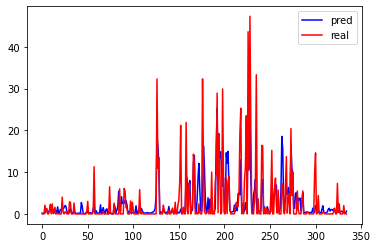

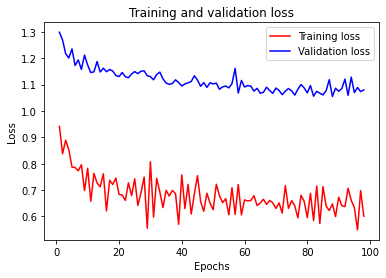

0.11560798980424833


In [1]:
import os
import json
from read_data import Reader
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
tf.random.set_seed(1)

def make_dataset():
    """
    To make tf.data.Dataset for training and test_x, test_y for testing and evaluation.
    :return: train_dataset, val_dataset, test_features, test_labels
    """
    reader = Reader()
    with open('E:\\rainfall\\RainPredDemo\\model\\config.json', 'r') as json_file:
        config = json.load(json_file)

    features = config['features']
    train = reader.read_many('train_resample_MD', features)
    val = reader.read_many('val_resample_MD', features)
    test = reader.read_many('test_resample_MD', features)

    train_mean = train.mean(axis=0)['RPH']
    train_std = train.std(axis=0)['RPH']

    def normalization(dataframe):
        return (dataframe - train.mean(axis=0)) / train.std(axis=0)

    def dataframe_to_dataset(dataframe, shuffle=True, repeat=True, batch_size=32):
        dataframe = dataframe.copy()
        labels = dataframe.pop('RPH')
        dataset = tf.data.Dataset.from_tensor_slices((dataframe, labels))
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(dataframe))
        dataset = dataset.batch(batch_size)
        if repeat:
            dataset = dataset.repeat()
        return dataset

    train, val, test = normalization(train), normalization(val), normalization(test)
    train_dataset = dataframe_to_dataset(train)
    val_dataset = dataframe_to_dataset(val, shuffle=False)
    test_labels = test.pop('RPH')
    test_features = test
    return train_dataset, val_dataset, test_features, test_labels, train_mean, train_std


def dense_model_sequential_1():
    """
    To make a model in a sequential way (way 1).
    Performs exactly the same as the two methods below.
    :return: Model established
    """
    model = tf.keras.Sequential()
    model.add(layers.Dense(7, activation='sigmoid'))
    model.add(layers.Dense(25, activation='sigmoid'))
    model.add(layers.Dense(1))

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.01
    )
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

    return model


def dense_model_sequential_2():
    """
    To make a model in a sequential way (way 2).
    :return: Model established.
    """
    model = tf.keras.Sequential([
        layers.Dense(7, activation='sigmoid'),
        layers.Dense(25, activation='sigmoid'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.01
    )
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

    return model


def dense_model_functional():
    """
    To make a model in a functional way, recommended.
    :return: Model established.
    """
    x = layers.Input(7)
    d = layers.Dense(7, activation='sigmoid')(x)
    d = layers.Dense(25, activation='sigmoid')(d)
    d = layers.Dense(1)(d)

    model = tf.keras.Model(inputs=x, outputs=d)
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.01
    )
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

    return model


if __name__ == '__main__':
    epochs = 200
    size_train, size_val = 2091, 713
    batch_size = 32 #32
    train_ds, val_ds, test_x, test_y, train_mean, train_std = make_dataset()
    model = dense_model_sequential_1()
    # model = dense_model_sequential_2()
    # model = dense_model_functional()
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=10, verbose=0,
        mode='auto', baseline=None, restore_best_weights=True
    )
    history = model.fit(train_ds, epochs=epochs, steps_per_epoch=size_train // batch_size,
                        validation_data=val_ds, validation_steps=size_val // batch_size,
                        callbacks=[callback])
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    print(model.summary())

    # if not os.path.exists('model'):
    #     os.makedirs('model')
    # model.save('model')

    # model = tf.keras.models.load_model('model')
    pred_y = model.predict(test_x)
    pred_y1=pred_y
    pred_y = pred_y * train_std + train_mean
    test_y = test_y * train_std + train_mean

    for index in range(len(pred_y)):
        if pred_y[index]<0:
            pred_y[index]=0

    # paint pred and real
    x = range(335)
    plt.plot(x, pred_y, label="pred", color="b")
    plt.plot(x, test_y, label="real", color="r")
    plt.legend()
    plt.show()
    plt.close()

    #paint loss and accuracy
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.close()

    #result
    print((test_y.mean()-pred_y.mean())/pred_y.mean())

In [2]:
test_half1 = test_y[:214]
test_half2 = test_y[214:]
pred_half1 = pred_y[:214]
pred_half2 = pred_y[214:]
print("202001-07 real rainfall: ",test_half1.sum())
print("202001-07 pred rainfall: ",pred_half1.sum())
print("real is bigger than pred by :",(test_half1.sum()-pred_half1.sum())/pred_half1.sum(),'\n')

print("202008-11 real rainfall: ",test_half2.sum())
print("202008-11 pred rainfall: ",pred_half2.sum())
print("real is bigger than pred by :",(test_half2.sum()-pred_half2.sum())/pred_half2.sum())

202001-07 real rainfall:  457.50000000000006
202001-07 pred rainfall:  486.3617
real is bigger than pred by : -0.059342038388414335 

202008-11 real rainfall:  486.40000000000003
202008-11 pred rainfall:  359.72406
real is bigger than pred by : 0.3521475319742934


In [3]:
from sklearn.metrics import r2_score
r_square = r2_score(y_true=test_y,y_pred=pred_y)
print("R-square is ",r_square)

R-square is  0.439135418174568
